# Random Forest

## References

https://www.kaggle.com/datasets/alarmanovi/gender-recognition-by-voice-2023

## Import Python Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Global Variables

In [3]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [4]:
# Source: https://www.kaggle.com/datasets/uciml/glass

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: Mean Frequency (mean_freq): Computed using Fast Fourier Transform (FFT). Represents the average frequency of the audio signal.
# X02: Standard Deviation of Frequency (sd_freq): Calculated using the standard deviation of the spectral centroid. Indicates the spread or variability of the spectral centroid.
# X03: Median Frequency (median_freq): Obtained from the median of the spectral centroid. Represents the middle value of the distribution of spectral centroid frequencies.
# X04: 25th Percentile Frequency (q25_freq): Quantiles of the spectral centroid. Provide information about the distribution of spectral centroid frequencies.
# X05: 75th Percentile Frequency (q75_freq): Quantiles of the spectral centroid. Provide information about the distribution of spectral centroid frequencies.
# X06: Interquartile Range of Frequency (iqr_freq): The range between the 25th and 75th percentiles. Measures the spread of the middle 50% of spectral centroid frequencies.
# X07: Skewness (skewness): Descriptive statistics of the spectral bandwidth. Indicate the shape of the spectral bandwidth distribution.
# X08: Kurtosis (kurtosis_val): Descriptive statistics of the spectral bandwidth. Indicate the shape of the spectral bandwidth distribution.
# X09: Spectral Flatness (spectral_flatness): Represents the flatness of the power spectrum. A measure of how noise-like or tonal the audio is.
# X10: tempogram: a mid-level representation of tempo information, is constructed to characterize tempo variation and local pulse in the audio signal.
# X11: Mode Frequency (mode_freq): Extracted from the tempogram. Represents the mode (most common) frequency in the audio signal.
# X12: Centroid Frequency (centroid_freq): The mean of the spectral centroid. Provides the center of mass of the spectral distribution.
# X13: Peak Frequency (peak_freq): The frequency with the highest amplitude in the spectral centroid. Indicates the dominant frequency in the audio signal.
# X14: mean_fun: Additional Features Related to Fundamental Frequency. Extracted from the root mean square (RMS) values. Provide information about the fundamental frequency.
# X15: min_fun: Additional Features Related to Fundamental Frequency. Extracted from the root mean square (RMS) values. Provide information about the fundamental frequency.
# X16: max_fun: Additional Features Related to Fundamental Frequency. Extracted from the root mean square (RMS) values. Provide information about the fundamental frequency.
# X17: mean_dom: Additional Features Related to Dominant Frequency. Derived from the tempogram. Offer insights into the dominant frequencies and their range.
# X18: min_dom: Additional Features Related to Dominant Frequency. Derived from the tempogram. Offer insights into the dominant frequencies and their range.
# X19: max_dom: Additional Features Related to Dominant Frequency. Derived from the tempogram. Offer insights into the dominant frequencies and their range.
# X20: dom_range: Additional Features Related to Dominant Frequency. Derived from the tempogram. Offer insights into the dominant frequencies and their range.
# X21: Modulation Index (mod_index): Calculated using the YIN algorithm. Indicates the degree of modulation in the audio signal.
#   y: Label (label): Assigned as 'female' or 'Male' for all processed audio files.

In [5]:
# load heart.csv dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/male_female_voice.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,mean_freq,sd_freq,median_freq,q25_freq,q75_freq,iqr_freq,skewness,kurtosis_val,spectral_flatness,tempogram,...,peak_freq,mean_fun,min_fun,max_fun,mean_dom,min_dom,max_dom,fund_freq,mod_index,label
0,0.101925,1258.484673,1.101064,0.911917,2.156636,0.001245,616.124085,-0.001148,0.004659,0.000133,...,166.0,0.000019,5.290000e-13,0.000064,0.132647,-0.0,1.0,205.312043,15.314357,male
1,0.141755,1087.412699,2.279823,1.597941,3.019070,0.001421,303.676155,-0.000125,0.000518,0.000146,...,153.0,0.000054,2.821115e-06,0.000133,0.146389,-0.0,1.0,239.989176,29.892067,male
2,0.086956,772.431710,0.833124,0.655712,1.613551,0.000958,517.743718,-0.000878,0.000444,0.000160,...,124.0,0.000011,3.726945e-07,0.000037,0.160206,-0.0,1.0,172.931651,10.603064,male
3,0.272180,754.611927,1.279489,1.062411,1.512505,0.000450,422.531605,0.000301,0.000230,0.000200,...,582.0,0.000013,3.742320e-06,0.000024,0.199956,-0.0,1.0,212.732706,32.122518,male
4,0.158995,634.740672,1.762929,1.479458,2.106728,0.000627,243.829730,0.000654,0.000110,0.000181,...,83.0,0.000071,1.527331e-05,0.000176,0.180945,-0.0,1.0,236.450792,9.935689,male


In [6]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'label'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [7]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,y
0,0.101925,1258.484673,1.101064,0.911917,2.156636,0.001245,616.124085,-0.001148,0.004659,0.000133,...,166.0,0.000019,5.290000e-13,0.000064,0.132647,-0.0,1.0,205.312043,15.314357,male
1,0.141755,1087.412699,2.279823,1.597941,3.019070,0.001421,303.676155,-0.000125,0.000518,0.000146,...,153.0,0.000054,2.821115e-06,0.000133,0.146389,-0.0,1.0,239.989176,29.892067,male
2,0.086956,772.431710,0.833124,0.655712,1.613551,0.000958,517.743718,-0.000878,0.000444,0.000160,...,124.0,0.000011,3.726945e-07,0.000037,0.160206,-0.0,1.0,172.931651,10.603064,male
3,0.272180,754.611927,1.279489,1.062411,1.512505,0.000450,422.531605,0.000301,0.000230,0.000200,...,582.0,0.000013,3.742320e-06,0.000024,0.199956,-0.0,1.0,212.732706,32.122518,male
4,0.158995,634.740672,1.762929,1.479458,2.106728,0.000627,243.829730,0.000654,0.000110,0.000181,...,83.0,0.000071,1.527331e-05,0.000176,0.180945,-0.0,1.0,236.450792,9.935689,male


In [8]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5993 entries, 0 to 5992
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     5993 non-null   float64
 1   X02     5993 non-null   float64
 2   X03     5993 non-null   float64
 3   X04     5993 non-null   float64
 4   X05     5993 non-null   float64
 5   X06     5993 non-null   float64
 6   X07     5993 non-null   float64
 7   X08     5993 non-null   float64
 8   X09     5993 non-null   float64
 9   X10     5993 non-null   float64
 10  X11     5993 non-null   float64
 11  X12     5993 non-null   float64
 12  X13     5993 non-null   float64
 13  X14     5993 non-null   float64
 14  X15     5993 non-null   float64
 15  X16     5993 non-null   float64
 16  X17     5993 non-null   float64
 17  X18     5993 non-null   float64
 18  X19     5993 non-null   float64
 19  X20     5993 non-null   float64
 20  X21     5993 non-null   float64
 21  y       5993 non-null   object 
dtype

In [9]:
# describe data
df1.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21
count,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,...,5993.000000,5993.000000,5993.000000,5.993000e+03,5993.000000,5993.000000,5.993000e+03,5993.0,5993.000000,5993.000000
mean,0.338481,761.020565,1.399165,1.146501,1.847132,0.000701,381.354844,0.000339,0.000707,0.000158,...,1634.933387,152.165360,0.000062,6.727932e-06,0.000159,0.157960,-1.668613e-19,1.0,253.216351,17.448611
std,0.219415,251.631901,0.356573,0.309548,0.475078,0.000316,84.400591,0.001562,0.001516,0.000028,...,369.815453,152.646278,0.000049,1.235205e-05,0.000108,0.027517,1.291748e-17,0.0,79.849107,14.326283
min,0.000000,118.480187,0.262302,0.195782,0.337625,0.000142,89.836751,-0.001594,0.000004,0.000069,...,304.178220,0.000000,0.000002,0.000000e+00,0.000006,0.068926,-1.000000e-15,1.0,74.446723,1.416494
25%,0.170927,574.123400,1.141308,0.920800,1.505274,0.000476,323.128816,-0.000570,0.000154,0.000139,...,1377.076408,63.000000,0.000030,7.644346e-07,0.000083,0.138638,0.000000e+00,1.0,195.598109,9.460127
50%,0.300113,763.274353,1.361954,1.107176,1.806362,0.000636,379.762545,-0.000079,0.000276,0.000158,...,1615.071173,126.000000,0.000047,2.846138e-06,0.000132,0.157960,0.000000e+00,1.0,243.309068,13.772405
75%,0.487619,940.165535,1.622377,1.330819,2.146770,0.000859,439.368299,0.000792,0.000516,0.000177,...,1880.262710,192.000000,0.000078,7.648991e-06,0.000207,0.176736,0.000000e+00,1.0,297.641142,20.540978
max,3.391885,1608.224040,3.356004,3.032274,4.186068,0.002374,679.505785,0.046115,0.059530,0.000252,...,3549.633359,3243.000000,0.000556,3.046583e-04,0.000775,0.252338,-0.000000e+00,1.0,801.780184,237.742628


In [10]:
# check missing values
df1.count()

X01    5993
X02    5993
X03    5993
X04    5993
X05    5993
X06    5993
X07    5993
X08    5993
X09    5993
X10    5993
X11    5993
X12    5993
X13    5993
X14    5993
X15    5993
X16    5993
X17    5993
X18    5993
X19    5993
X20    5993
X21    5993
y      5993
dtype: int64

## Data Cleaning

Not Needed

## Transform Dataset

In [11]:
# response column
y_col = new_y_col
y_col

'y'

In [12]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21'],
      dtype='object')

In [13]:
# get unique y_labels
y_labels = df1.y.unique()
# y_labels = {y_labels[i]: i for i in range(len(y_labels))}
y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{0: 'male', 1: 'female'}

In [14]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,y
0,0.101925,1258.484673,1.101064,0.911917,2.156636,0.001245,616.124085,-0.001148,0.004659,0.000133,...,166.0,0.000019,5.290000e-13,0.000064,0.132647,-0.0,1.0,205.312043,15.314357,male
1,0.141755,1087.412699,2.279823,1.597941,3.019070,0.001421,303.676155,-0.000125,0.000518,0.000146,...,153.0,0.000054,2.821115e-06,0.000133,0.146389,-0.0,1.0,239.989176,29.892067,male
2,0.086956,772.431710,0.833124,0.655712,1.613551,0.000958,517.743718,-0.000878,0.000444,0.000160,...,124.0,0.000011,3.726945e-07,0.000037,0.160206,-0.0,1.0,172.931651,10.603064,male
3,0.272180,754.611927,1.279489,1.062411,1.512505,0.000450,422.531605,0.000301,0.000230,0.000200,...,582.0,0.000013,3.742320e-06,0.000024,0.199956,-0.0,1.0,212.732706,32.122518,male
4,0.158995,634.740672,1.762929,1.479458,2.106728,0.000627,243.829730,0.000654,0.000110,0.000181,...,83.0,0.000071,1.527331e-05,0.000176,0.180945,-0.0,1.0,236.450792,9.935689,male


In [15]:
# normalize all X_cols
df2 = df1.copy()
# norm = StandardScaler()
# norm = MinMaxScaler()
norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,y
0,-0.625804,1.352878,-0.542312,-0.476219,0.546028,1.590373,2.033401,-0.784846,12.096719,-0.664406,...,0.310078,-0.596269,-0.413409,-0.547242,-0.664406,-0.0,0.0,-0.372363,0.139155,male
1,-0.500035,0.885522,1.907977,1.196930,1.890439,2.051039,-0.654566,-0.033752,0.667300,-0.303708,...,0.209302,0.142609,-0.003635,0.006793,-0.303708,-0.0,0.0,-0.032534,1.454731,male
2,-0.673071,0.025017,-1.099281,-1.101079,-0.300564,0.841231,1.187042,-0.586224,0.465501,0.058954,...,-0.015504,-0.745247,-0.359274,-0.762550,0.058954,-0.0,0.0,-0.689684,-0.286020,male
3,-0.088200,-0.023665,-0.171419,-0.109179,-0.458080,-0.484659,0.367939,0.279177,-0.125233,1.102322,...,3.534884,-0.705762,0.130173,-0.873100,1.102322,-0.0,0.0,-0.299642,1.656020,male
4,-0.445600,-0.351144,0.833508,0.907960,0.468229,-0.021991,-1.169420,0.538728,-0.456550,0.603322,...,-0.333333,0.490912,1.805080,0.358758,0.603322,-0.0,0.0,-0.067210,-0.346247,male


In [16]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 2) | (df2[X] <= -2))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

In [17]:
# melt df2 into a dataframe where cols become stacked as rows
df3 = df2.melt(
  id_vars = y_col,
  value_vars = X_cols,
  var_name = 'X',
  value_name = "X_value"
)
df3.head()

,y,X,X_value
0,male,X01,-0.625804
1,male,X01,-0.500035
2,male,X01,-0.673071
3,male,X01,-0.088200
4,male,X01,-0.445600


## Visualize Dataset

In [18]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (20, 30)

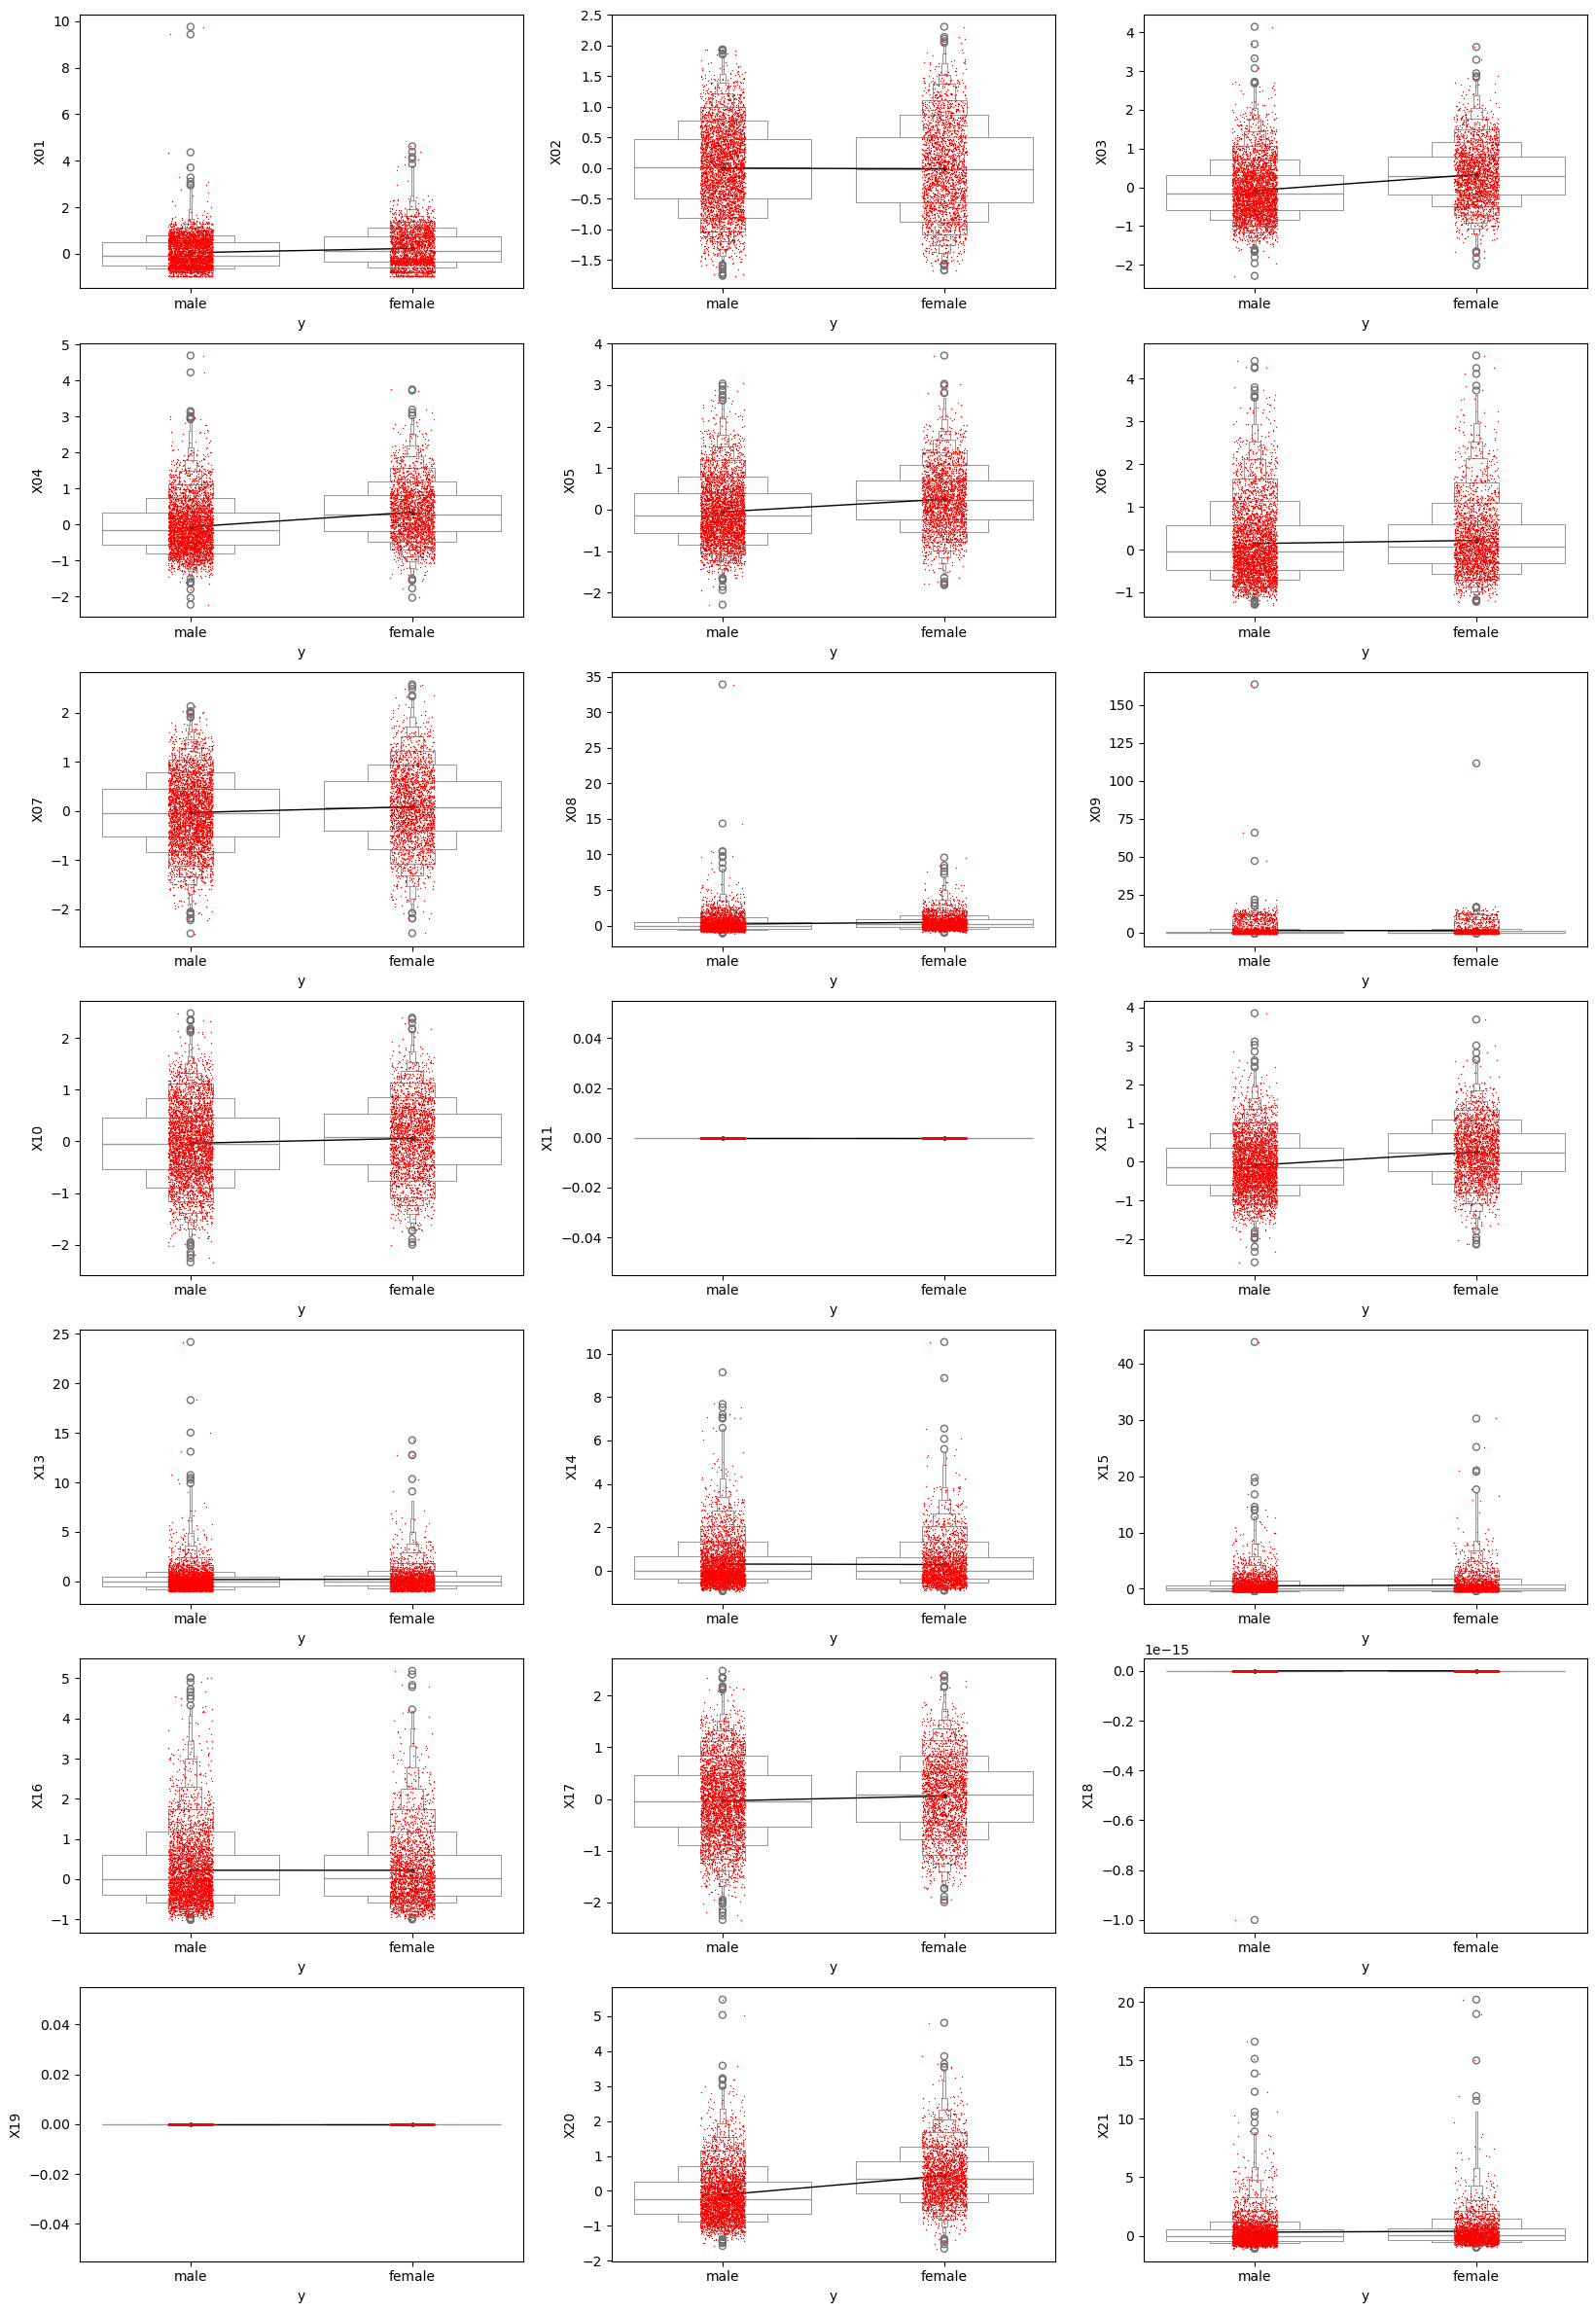

In [19]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Remove Features Having % Similar Values or More

In [20]:
# porportion similar (p)
p = 1
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

1 0


In [21]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [22]:
# fit model
temp = myfit.fit_transform(df2[X_cols])
temp.shape

(5993, 19)

In [23]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X20',
       'X21'], dtype=object)

In [24]:
# update X_cols
X_cols = X_cols_var_threshold
X_cols

array(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X20',
       'X21'], dtype=object)

### Select Features Using Model Selection Methods

In [149]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [235]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 10,
  max_depth = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [236]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [237]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.05610136, 0.05502195, 0.06993528, 0.05647916, 0.04240292,
       0.04226791, 0.10014232, 0.09001309, 0.03734952, 0.0327261 ,
       0.04963102, 0.03402736, 0.02988077, 0.03324369, 0.03356164,
       0.03376742, 0.        , 0.14918123, 0.05426727])

In [238]:
# threshold feature importance
feature_importance_threshold = np.mean(feature_importance)
# feature_importance_threshold = np.median(feature_importance)
# feature_importance_threshold = np.quantile(feature_importance, q = 0.5)
feature_importance_threshold

0.05263157894736842

In [239]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = feature_importance_threshold
)

In [240]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [241]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X01', 'X02', 'X03', 'X04', 'X07', 'X08', 'X20', 'X21'],
      dtype=object)

## Train and Test ML Model

In [242]:
# X_cols to include after feature selection
# X_include = X.columns
X_include = X_cols_rf
print(len(X_include))
print(X_include)

8
['X01' 'X02' 'X03' 'X04' 'X07' 'X08' 'X20' 'X21']


In [243]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X[X_include], y, 
  stratify = y, shuffle = True, 
  train_size = 0.7, random_state = random_state
)

In [274]:
# initialize Random Forest model
myfit = RandomForestClassifier(
  criterion = 'log_loss',
  # min_samples_split = 10,
  random_state = random_state
)

In [275]:
# fit model
temp = myfit.fit(X_train, y_train)

In [276]:
# get predictions on test data
y_hat = myfit.predict(X_test)

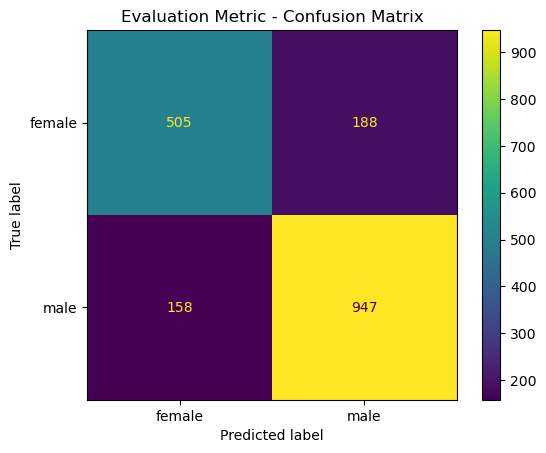

In [277]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [278]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

      female       0.76      0.73      0.74       693
        male       0.83      0.86      0.85      1105

    accuracy                           0.81      1798
   macro avg       0.80      0.79      0.80      1798
weighted avg       0.81      0.81      0.81      1798

